## Neural Networks: Regression

In [79]:
#!pip install torch

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns # for plotting

# various PyTorch things for NNs
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split, DataLoader

# if you want reproducability, set random seeds:
# np.random.seed(42)
# torch.manual_seed(42)

In [81]:
df = pd.read_csv('topic3-spiral.csv')

def regression(row):
    if row['arm'] == 0:
        return np.random.normal(100,25)
    else:
        return np.random.normal(200,25)
        

df['value'] = df.apply(regression, axis=1)

df.iloc[:5]

,x,y,arm,value
0,0.361659,-1.815359,0,66.604745
1,-0.080207,0.467795,0,108.057598
2,-1.236511,-0.940904,0,54.340891
3,-0.568537,0.013438,0,116.758458
4,-0.004653,-0.019253,0,89.291839


<Axes: xlabel='x', ylabel='y'>

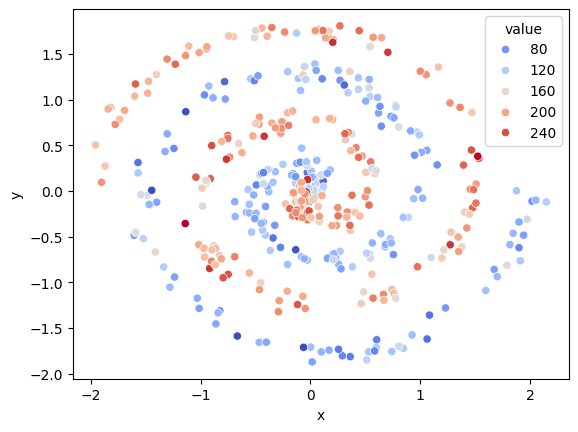

In [82]:
sns.scatterplot(data=df, x='x', y='y', hue='value', palette="coolwarm")

**Change #1:** When defining the model architecture, ensure that the ouput layer contains only one neuron.

**Change #2:** Also, use no activation function in the output layer. Our output can be any number since this is a regression problem, so we don't need to specify any ranges or conditions for what the prediction can be.

**Change #3:** We will use a new loss function. This is how the neural network decided how good or bad a model performs. Don't worry about the math behind it (it's very advanced), but we used Binary Cross Entropy for a binary problem, Cross Entropy for a non-binary problem, and now Mean Squared Error (MSE) Loss for a regression problem.

In [83]:
# Define the model architecture
class NNModelAdam(nn.Module):
    def __init__(self, dropout_rate=0):
        super(NNModelAdam, self).__init__()
        self.fc1 = nn.Linear(2, 8) # input has 2 neurons ('x' and 'y'), hidden layer 1 has 8 neurons
        self.fc2 = nn.Linear(8, 8) # hidden layer 1 has 8 neurons, hidden layer 2 has 8 neurons
        self.fc3 = nn.Linear(8, 4) # hidden layer 2 has 8 neurons, hidden layer 3 has 4 neurons
        self.fc4 = nn.Linear(4, 1) # hidden layer 3 has 4 neurons, output layer has 1 neuron (probability)
        self.dropout = nn.Dropout(dropout_rate)  # dropout with the default rate specified above

    def forward(self, x):
        x = F.relu(self.fc1(x)) # use ReLU activation function on hidden layer 1
        x = self.dropout(x) # dropout neurons in hidden layer 1
        x = F.relu(self.fc2(x)) # use ReLU activation function on hidden layer 2
        x = self.dropout(x) # dropout neurons in hidden layer 2
        x = F.relu(self.fc3(x)) # use ReLU activation function on hidden layer 3
        x = self.dropout(x) # dropout neurons in hidden layer 3
        x = self.fc4(x) # don't apply any activation function in the last layer for regression
        return x

# Instantiate the model
model = NNModelAdam()

# Loss function and optimizer
criterion = nn.MSELoss()  # use Mean Squared Error (MSE) for loss
optimizer = optim.Adam(model.parameters(), lr=0.01) # make updates with a learning rate of 0.01

**Change #4:** Here, we're going to use the same data shape that we used for y in a Binary Classification problem, rather than the shape from the Multi-Class Classification problem.

In [84]:
# Prepare data
X = torch.tensor(np.stack([df['x'], df['y']], axis=1), dtype=torch.float32)
y = torch.tensor(df['value'].values.reshape(-1, 1), dtype=torch.float32)
dataset = TensorDataset(X, y)

train_ds, val_ds = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_dl = DataLoader(train_ds, batch_size=50, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=50)

**Change #5:** We need to extract the predicted value so we can calculate the absolute error from the true value.

In [85]:
# Training loop for regression
num_epochs = 100

for epoch in range(num_epochs):
    def run_epoch(dataloader, training=True):
        model.train() if training else model.eval()
        total_loss, total_abs_error, total_samples = [], 0, 0

        for xb, yb in dataloader:
            preds = model(xb)  # Get predictions (raw output for regression)
            loss = criterion(preds, yb)  # MSE Loss

            if training:
                optimizer.zero_grad()  # Set gradients to zero
                loss.backward()  # Perform backpropagation
                optimizer.step()  # Update model parameters

            total_loss.append(loss.item())  # Add loss to total

            # Compute Mean Absolute Error (MAE)
            abs_error = torch.abs(preds - yb).sum().item()  # Sum of absolute errors for the batch
            total_abs_error += abs_error
            total_samples += yb.size(0)

        avg_loss = np.mean(total_loss)  # Average loss over all batches
        avg_abs_error = total_abs_error / total_samples  # Mean Absolute Error
        return avg_loss, avg_abs_error

    train_loss, train_mae = run_epoch(train_dl, training=True)
    val_loss, val_mae = run_epoch(val_dl, training=False)

    print(f"Epoch {epoch+1:3d} | "
          f"Train Loss: {train_loss:.4f} | Train MAE: {train_mae:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f}")


Epoch   1 | Train Loss: 25271.0248 | Train MAE: 150.3513 | Val Loss: 26908.5596 | Val MAE: 152.7772
Epoch   2 | Train Loss: 25486.2115 | Train MAE: 150.1135 | Val Loss: 26813.1904 | Val MAE: 152.4691
Epoch   3 | Train Loss: 25849.2640 | Train MAE: 149.6692 | Val Loss: 26602.8174 | Val MAE: 151.7847
Epoch   4 | Train Loss: 24364.5812 | Train MAE: 148.6251 | Val Loss: 26137.7246 | Val MAE: 150.2640
Epoch   5 | Train Loss: 24428.1275 | Train MAE: 146.4504 | Val Loss: 25241.4746 | Val MAE: 147.2898
Epoch   6 | Train Loss: 23475.0561 | Train MAE: 142.2861 | Val Loss: 23618.3262 | Val MAE: 141.7371
Epoch   7 | Train Loss: 20461.3302 | Train MAE: 134.7588 | Val Loss: 20932.9258 | Val MAE: 132.0069
Epoch   8 | Train Loss: 17172.4753 | Train MAE: 121.7723 | Val Loss: 16947.6465 | Val MAE: 115.9841
Epoch   9 | Train Loss: 13198.4651 | Train MAE: 101.6377 | Val Loss: 11860.7090 | Val MAE: 91.9002
Epoch  10 | Train Loss: 7881.8414 | Train MAE: 74.7798 | Val Loss: 6876.1602 | Val MAE: 67.7486
Epoch

**Change #6:** Again, we need to extract the predicted value from the neural network. Then, we can plot based on this predicted value instead of the predicted class or predicted probability.

Val MAE: 53.93


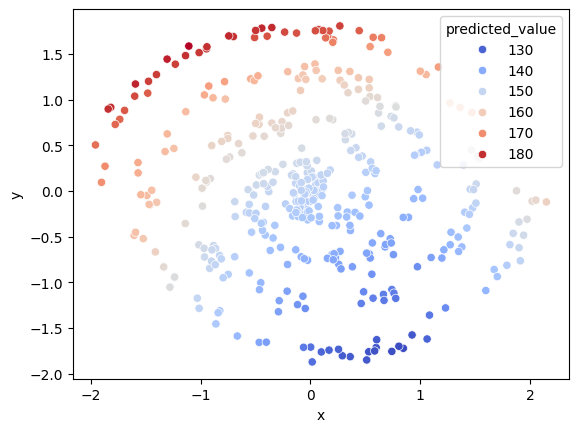

In [86]:
# Make sure the model is in evaluation mode
model.eval()

# Prepare the input data from the dataframe (assumes 'x' and 'y' are the input features)
inputs = torch.tensor(df[['x', 'y']].values, dtype=torch.float32)

# Get predictions (model outputs raw values for regression)
with torch.no_grad():
    predictions = model(inputs)  # Raw regression outputs (not probabilities)

# Convert predicted values to a numpy array and add them as a new column to the dataframe
df['predicted_value'] = predictions.numpy()

# Check the updated dataframe
sns.scatterplot(data=df, x='x', y='y', hue='predicted_value', palette="coolwarm")
print(f"Val MAE: {round(val_mae,2)}")

As a reminder, here are the **hyperparameters** you can tune to try and improve your Neural Network. 

Play around with any and all of these to see what seems to work best!

- Number of hidden layers in the NN
- Number of neurons in each layer of the NN
- Activation function at each layer in the NN
- Whether or not you need regularization (dropout) to mitigate overfitting
- If so, what proportion of neurons should you drop out after each layer?
- Number of epochs
- Batch size
- Learning rate